# Model Training

This notebook covers training and evaluating the sentiment analysis model.

## Imports

In [1]:
import sys
import os

# Get the absolute path of the parent directory
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to the system path
if parent_directory not in sys.path:
    sys.path.append(parent_directory)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

import numpy as np

import matplotlib.pyplot as plt

### Load Tokenizer

In [3]:
import pickle

tokenizer_path = os.path.join(parent_directory, "app\\tokenizer\\tokenizer.pickle")

# Load the tokenizer
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

### Load Processed Data

In [4]:
processed_data_directory = os.path.join(parent_directory, "data\\processed")

# Load processed data
train_padded = np.load(os.path.join(processed_data_directory, "train_padded.npy"))
train_labels = np.load(os.path.join(processed_data_directory, "train_labels.npy"))
test_padded = np.load(os.path.join(processed_data_directory, "test_padded.npy"))
test_labels = np.load(os.path.join(processed_data_directory, "test_labels.npy"))

### Model Selection

In [5]:
# GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = os.path.join(parent_directory, "glove.6B\\glove.6B.100d.txt")

glove_embeddings = load_glove_embeddings(glove_path, 100)

embedding_dim = 100
vocab_size = 10000

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [6]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=120, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model by providing the input shape
model.build(input_shape=(None, 120))

# Display the model summary
model.summary()

c:\Users\ckand\OneDrive\Desktop\imdb_sentiment\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 120, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,407,169 (5.37 MB)

 Trainable params: 407,169 (1.55 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

### Model Training

In [7]:
# Train the model
history = model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_data=(test_padded, test_labels))

# Save the model
model_directory = os.path.join(parent_directory, "app\\models\\imdb_sentiment.keras")

model.save(model_directory)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 112s 135ms/step - accuracy: 0.6361 - loss: 0.6217 - val_accuracy: 0.7855 - val_loss: 0.4475
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 132s 169ms/step - accuracy: 0.7957 - loss: 0.4403 - val_accuracy: 0.8082 - val_loss: 0.4164
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 105s 135ms/step - accuracy: 0.8237 - loss: 0.3895 - val_accuracy: 0.8421 - val_loss: 0.3536
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 113s 145ms/step - accuracy: 0.8462 - loss: 0.3475 - val_accuracy: 0.8501 - val_loss: 0.3378
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 150ms/step - accuracy: 0.8639 - loss: 0.3156 - val_accuracy: 0.8502 - val_loss: 0.3375
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 122s 157ms/step - accuracy: 0.8772 - loss: 0.2856 - val_accuracy: 0.8550 - val_loss: 0.3271
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 119s 152ms/step - accuracy: 0.8923 - loss: 0.2605 - val_accuracy: 0.8591 - val_loss: 0.3303
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.9064 -

### Plot Training History

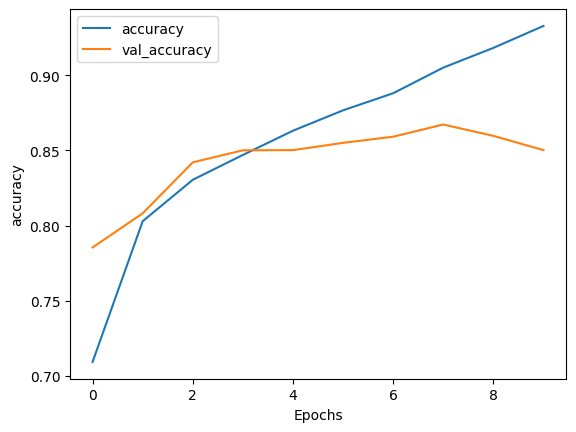

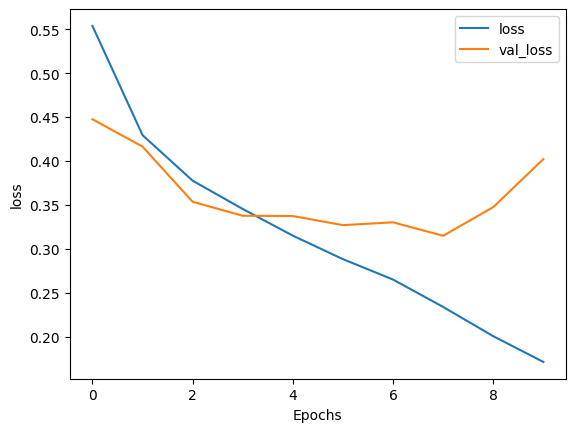

In [8]:
# Plot training history
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Debugging

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model on test data
test_predictions = model.predict(test_padded)
test_predictions = (test_predictions > 0.5).astype(int)

print(classification_report(test_labels, test_predictions))
print(confusion_matrix(test_labels, test_predictions))

782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     12500
           1       0.81      0.91      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000

[[ 9863  2637]
 [ 1108 11392]]


In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sample_texts = ["I don't really like this movie.", "I don't like this movie", "I really hate this movie", "I hate this movie", "I don't hate this movie", "I don't love this movie", "This is a terrible movie.", "It's okay, not great.", "Worst movie ever."]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=120, padding='post')

predictions = model.predict(sample_padded)
for i, text in enumerate(sample_texts):
    sentiment = 'positive' if predictions[i] > 0.5 else 'negative'
    confidence = predictions[i] if sentiment == 'positive' else 1 - predictions[i]
    print(f'Text: {text}\nSentiment: {sentiment}, Confidence: {confidence}\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Text: I don't really like this movie.
Sentiment: positive, Confidence: [0.91568625]

Text: I don't like this movie
Sentiment: positive, Confidence: [0.7352492]

Text: I really hate this movie
Sentiment: negative, Confidence: [0.5395732]

Text: I hate this movie
Sentiment: negative, Confidence: [0.50560755]

Text: I don't hate this movie
Sentiment: negative, Confidence: [0.690666]

Text: I don't love this movie
Sentiment: positive, Confidence: [0.97763693]

Text: This is a terrible movie.
Sentiment: negative, Confidence: [0.9956443]

Text: It's okay, not great.
Sentiment: positive, Confidence: [0.62396747]

Text: Worst movie ever.
Sentiment: negative, Confidence: [0.9962669]



We can see a problem here that the model notes some of the texts that should be marked as negative, positive. Words such as "don't" or "hate" have some affect to the confidence and slightly push the sentiment to negative, but it seems like words like "really" and "like" bump the sentiment back to positive. It seems like the trained model cannot recognize the fact that the sentiment can change with even a word difference. It also seems like some extremely negative words such as "hate" or "despise" affects the sentiment in a slightly significant way, but not significant enough. As we can see in our examples, we can see how the sentence "I don't hate this movie" has a higher confidence level in the negative sentiment compared to "I hate this movie". This shows that the presence of the word "don't" directly affects the sentiment negatively, no matter what word it is actually "don't"-ing.

### BERT

In [29]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import pipeline


# Load pre-trained BERT model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name)

# Create a pipeline for sentiment analysis
nlp = pipeline("sentiment-analysis", model=bert_model, tokenizer=bert_tokenizer)

# Test the pipeline
texts = ["I don't really like this movie.", "I don't like this movie", "I really hate this movie", "I hate this movie", "I don't hate this movie", "I don't love this movie", "This is a terrible movie.", "It's okay, not great.", "Worst movie ever."]
results = nlp(texts)
for text, result in zip(texts, results):
    print(f'Text: {text}\nSentiment: {result["label"]}, Confidence: {result["score"]}\n')

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Text: I don't really like this movie.
Sentiment: 2 stars, Confidence: 0.5714195966720581

Text: I don't like this movie
Sentiment: 1 star, Confidence: 0.5883395075798035

Text: I really hate this movie
Sentiment: 1 star, Confidence: 0.9208844304084778

Text: I hate this movie
Sentiment: 1 star, Confidence: 0.9108534455299377

Text: I don't hate this movie
Sentiment: 1 star, Confidence: 0.5840285420417786

Text: I don't love this movie
Sentiment: 1 star, Confidence: 0.5158706307411194

Text: This is a terrible movie.
Sentiment: 1 star, Confidence: 0.9341957569122314

Text: It's okay, not great.
Sentiment: 3 stars, Confidence: 0.8209234476089478

Text: Worst movie ever.
Sentiment: 1 star, Confidence: 0.926401674747467



In this BERT model, we can also see a similar error. It is certainly better than my model above, but we can also see how the sentence "I don't hate this movie" has a higher confidence in the 1 star sentiment compared to "I don't love this movie", although in reality, the sentence "I don't love this movie" should grammatically represent a more negative review than a "I don't hate this movie". It can be seen that certain words are overrepresented in this example. 